# Random Forest Baseline for PLT Reduction Prediction

## Task
- Binary classification
- Target: PLT reduction (0 = normal, 1 = reduced)

## Model
- Random Forest Classifier (sklearn)

## Metrics
- Accuracy
- Precision
- Recall
- F1-score
- ROC-AUC
- PR-AUC

## Notes
This notebook serves as the baseline model.

In [31]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict, StratifiedKFold, LeaveOneOut
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    average_precision_score,
    roc_curve,
    precision_recall_curve
)

plt.rcParams["font.sans-serif"] = ["SimHei"]  # 黑体
plt.rcParams["axes.unicode_minus"] = False
plt.rcParams["figure.dpi"] = 120
sns.set_style("whitegrid")

In [32]:
RANDOM_STATE = 42
TEST_SIZE = 0.2

TARGET_COL = "PLT 减少事件分组"
DATA_PATH = "../data/PLTdataset.xlsx"
SHEET_NAME = "血小板减少预测"

In [33]:
df = pd.read_excel(DATA_PATH, sheet_name=SHEET_NAME)

print("Data shape:", df.shape)
df.head()

Data shape: (63, 36)


,样本名称,"PLT count(0,>100,1,<100)",PLT 减少事件分组,PLT 严重程度分组,Gender（女，0；男，1）,动脉血栓（有1，无0）,"FHb(1,>40mg/L;0,<40mg/L)","FHb(1,>40mg/L;0,<40mg/L).1",LDH,"RDW1(0<15%,1≥15%",...,WBC,NC,STO,FIB,D dimer,NO,CHO,LDL,Pla(脂蛋白a),SOD
0,N1,135.0,0.0,0.0,0.0,0.0,19.974734,0.0,237.0,13.7,...,5.90,3.14,25.2,2.13,8.26,28.5,4.28,1.88,0.55,72.0
1,N10,143.0,0.0,0.0,1.0,1.0,20.367691,0.0,273.0,15.0,...,5.50,3.50,18.0,2.30,0.39,49.0,3.17,1.39,0.10,45.0
2,N11,116.0,0.0,0.0,1.0,1.0,49.988801,1.0,167.0,15.2,...,10.21,7.12,5.0,2.38,25.17,34.5,3.70,2.24,0.10,101.0
3,N12,156.0,0.0,0.0,1.0,0.0,14.744621,0.0,216.0,15.0,...,4.21,2.98,5.0,2.30,0.66,30.0,7.82,3.94,0.31,90.0
4,N13,138.0,0.0,0.0,1.0,0.0,15.565815,0.0,125.0,14.7,...,6.90,4.76,5.0,2.42,0.73,35.5,3.48,1.66,0.15,133.0


In [34]:
df.info()

df[TARGET_COL].value_counts(normalize=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63 entries, 0 to 62
Data columns (total 36 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   样本名称                                       62 non-null     object 
 1   PLT count(0,>100,1,<100)                   62 non-null     float64
 2   PLT 减少事件分组                                 62 non-null     float64
 3   PLT 严重程度分组                                 62 non-null     float64
 4   Gender（女，0；男，1）                            62 non-null     float64
 5   动脉血栓（有1，无0）                                62 non-null     float64
 6   FHb(1,>40mg/L;0,<40mg/L)                   62 non-null     float64
 7   FHb(1,>40mg/L;0,<40mg/L).1                 62 non-null     float64
 8   LDH                                        62 non-null     float64
 9   RDW1(0<15%,1≥15%                           62 non-null     float64
 10  RDW1(0<15%,1≥15%.1          

PLT 减少事件分组
0.0    0.516129
1.0    0.483871
Name: proportion, dtype: float64

In [35]:
DROP_COLS = ["样本名称", "PLT count(0,>100,1,<100)", "PLT 严重程度分组", "Gender（女，0；男，1）", "动脉血栓（有1，无0）", "FHb(1,>40mg/L;0,<40mg/L).1", "TM(>5450,1;≤5450，0，正常范围5450±2140)pg/mL).1", "PLA2（0<659IU/L,1≥659IU/L）.1", " HGB（1<100mg/L,2≥100mg/L）", "MCV(0<100fL,1≥100mfL).1", "RDW1(0<15%,1≥15%.1", "HDL（0≥0.8mmol/L,1<0.8mmol/L）.1", "FVIII(0.<120;1,>120%).1", TARGET_COL]
X = df.drop(columns=DROP_COLS)
y = df[TARGET_COL]

In [36]:
print("Missing values:")
print(X.isna().sum().sort_values(ascending=False))

X = X.dropna()
y = y.loc[X.index]

X = pd.get_dummies(X, drop_first=True)
print("Feature shape after encoding:", X.shape)

Missing values:
FHb(1,>40mg/L;0,<40mg/L)                   1
LDH                                        1
Pla(脂蛋白a)                                  1
LDL                                        1
CHO                                        1
NO                                         1
D dimer                                    1
FIB                                        1
STO                                        1
NC                                         1
WBC                                        1
Age                                        1
FVIII(0.<120;1,>120%)                      1
HDL（0≥0.8mmol/L,1<0.8mmol/L）               1
 HGB（1<100mg/L,0≥100mg/L）                  1
PLA2（0<659IU/L,1≥659IU/L）                  1
脾大（1,是，0否）                                 1
CRP                                        1
TM(>5450,1;≤5450，0，正常范围5450±2140)pg/mL)    1
RDW1(0<15%,1≥15%                           1
SOD                                        1
MCV(0<100fL,1≥100mfL)                  

In [37]:
# X_train, X_test, y_train, y_test = train_test_split(
#     X,
#     y,
#     test_size=TEST_SIZE,
#     random_state=RANDOM_STATE,
#     stratify=y
# )

# print("Train:", X_train.shape)
# print("Test:", X_test.shape)

In [38]:
# rf = RandomForestClassifier(
#     n_estimators=200,
#     max_depth=None,
#     random_state=RANDOM_STATE,
#     n_jobs=-1
# )

In [39]:
# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# cv_scores = cross_val_score(rf, X_train, y_train, cv=cv, scoring='accuracy')

# print(f"5折交叉验证的各项得分：, {cv_scores}")
# print(f"5折平均得分：, {cv_scores.mean():.4f}")

In [40]:
# rf.fit(X_train, y_train)

rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')

# 1. 定义你想要尝试的“配方清单” (超参数网格)
param_grid = {
    'n_estimators': [30, 50, 80],  # 试试 100 棵树、200 棵、300 棵
    'max_depth': [2, 3],      # 试试不限深度、深度 10、深度 20
    'min_samples_split': [4, 6, 8],      # 试试不同的分裂节点要求
    'min_samples_leaf': [2, 3]
}

cv_5fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 2. 创建一个“搜索器”，它自带 5 折交叉验证功能
# 它会把上面的组合全部跑一遍（3 * 3 * 2 = 18 种组合），每种组合跑 5 次交叉验证
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    cv=cv_5fold, # 五折交叉验证
    scoring='f1',
    n_jobs=-1
)

# 3. 这里的 fit 意义重大了！
# 它会寻找 18 种组合中表现最好的一种，并自动用“表现最好的那套参数”在全部 X_train 上重新训练一遍
grid_search.fit(X, y)

# 4. 拿到那个“被交叉验证选中的最强者”
best_rf = grid_search.best_estimator_

# 5. 查看到底哪套参数最好
print("RF 最佳 F1:", grid_search.best_score_)
print("RF 最佳参数:", grid_search.best_params_)

RF 最佳 F1: 0.9846153846153847
RF 最佳参数: {'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 30}


In [41]:
# y_pred = best_rf.predict(X_test)
# y_prob = best_rf.predict_proba(X_test)[:, 1]

loo = LeaveOneOut()

y_probas_loo = cross_val_predict(best_rf, X, y, cv=loo, method='predict_proba')[:, 1]
y_preds_loo = (y_probas_loo > 0.5).astype(int)

In [42]:
metrics = {
    "accuracy": accuracy_score(y, y_preds_loo),
    "precision": precision_score(y, y_preds_loo),
    "recall": recall_score(y, y_preds_loo),
    "f1": f1_score(y, y_preds_loo),
    "roc_auc": roc_auc_score(y, y_probas_loo),
    "pr_auc": average_precision_score(y, y_probas_loo)
}

metrics_df = pd.DataFrame(metrics, index=["RandomForest"])
metrics_df

,accuracy,precision,recall,f1,roc_auc,pr_auc
RandomForest,0.967742,0.9375,1.0,0.967742,0.992708,0.991624


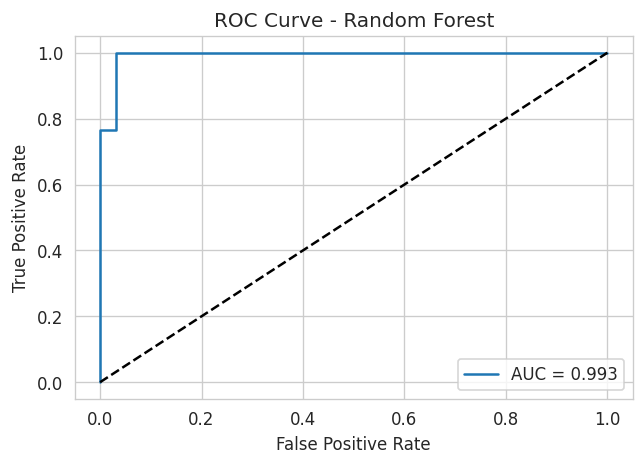

In [43]:
fpr, tpr, _ = roc_curve(y, y_probas_loo)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {metrics['roc_auc']:.3f}")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend()
plt.show()

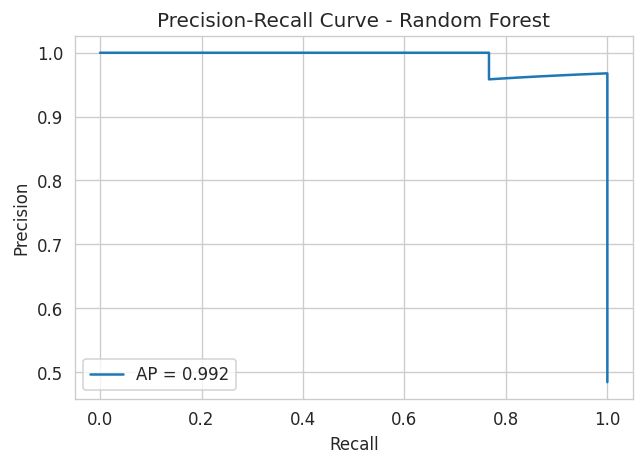

In [44]:
precision, recall, _ = precision_recall_curve(y, y_probas_loo)

plt.figure()
plt.plot(recall, precision, label=f"AP = {metrics['pr_auc']:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Random Forest")
plt.legend()
plt.show()

/tmp/ipykernel_881/1185338118.py:10: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_881/1185338118.py:10: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_881/1185338118.py:10: UserWarning: Glyph 65292 (\N{FULLWIDTH COMMA}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_881/1185338118.py:10: UserWarning: Glyph 27491 (\N{CJK UNIFIED IDEOGRAPH-6B63}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_881/1185338118.py:10: UserWarning: Glyph 24120 (\N{CJK UNIFIED IDEOGRAPH-5E38}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_881/1185338118.py:10: UserWarning: Glyph 33539 (\N{CJK UNIFIED IDEOGRAPH-8303}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_881/1185338118.py:10: UserWarning: Glyph 22260 (\N{CJK UNIFIED IDEOGRAPH-56F4}) missing from current font.
  plt.tight_layout()
/tmp/ipyk

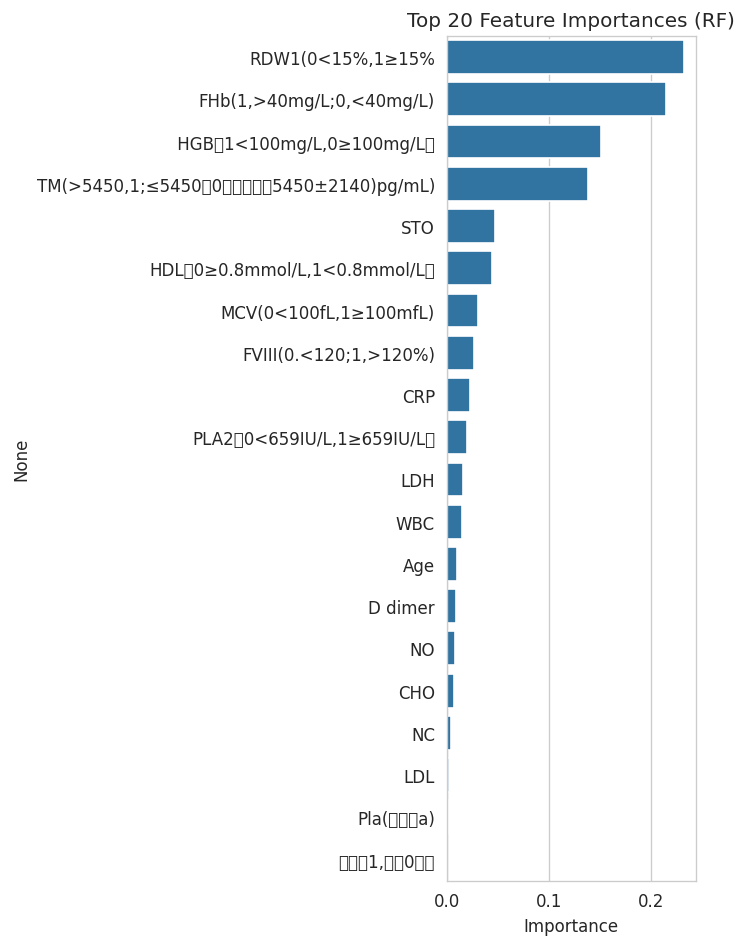


Top 10 Important Features:
RDW1(0<15%,1≥15%                           0.231904
FHb(1,>40mg/L;0,<40mg/L)                   0.213847
 HGB（1<100mg/L,0≥100mg/L）                  0.151190
TM(>5450,1;≤5450，0，正常范围5450±2140)pg/mL)    0.138420
STO                                        0.047277
HDL（0≥0.8mmol/L,1<0.8mmol/L）               0.044014
MCV(0<100fL,1≥100mfL)                      0.030499
FVIII(0.<120;1,>120%)                      0.026660
CRP                                        0.022792
PLA2（0<659IU/L,1≥659IU/L）                  0.019938
dtype: float64


In [45]:
feat_imp = pd.Series(
    best_rf.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

plt.figure(figsize=(6, 8))
sns.barplot(x=feat_imp.head(20), y=feat_imp.head(20).index)
plt.title("Top 20 Feature Importances (RF)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

print("\nTop 10 Important Features:")
print(feat_imp.head(10))

In [46]:
metrics_df.to_csv("../outputs/rf_metrics.csv")
feat_imp.to_csv("../outputs/rf_feature_importance.csv")

plt.savefig("../outputs/rf_feature_importance.png", dpi=300)

<Figure size 720x480 with 0 Axes>

In [47]:
# 找出哪些行存在缺失
df[df.isna().any(axis=1)]

,样本名称,"PLT count(0,>100,1,<100)",PLT 减少事件分组,PLT 严重程度分组,Gender（女，0；男，1）,动脉血栓（有1，无0）,"FHb(1,>40mg/L;0,<40mg/L)","FHb(1,>40mg/L;0,<40mg/L).1",LDH,"RDW1(0<15%,1≥15%",...,WBC,NC,STO,FIB,D dimer,NO,CHO,LDL,Pla(脂蛋白a),SOD
62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Summary

- Random Forest baseline completed
- PR-AUC suggests model performance under class imbalance
- Top features identified for further analysis

Next steps:
- XGBoost
- LightGBM
- Threshold tuning